In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
#import pandas as pd
import numpy as np
import cv2

def get_dataset(csv_in):
    
    all_joints = pd.read_csv(csv_in, delimiter=" ", header = None)
    all_joints.columns = ["file","k1_x","k1_y","k2_x","k2_y","k3_x","k3_y","k4_x","k4_y",
                      "k5_x","k5_y","k6_x","k6_y","k7_x","k7_y","k8_x","k8_y"]
    return all_joints


def get_joints_files_from_df(df):
    
    joints = np.array(df.iloc[:,1:17])
    files = np.array(df.iloc[:,0])
    
    return joints, files


def get_joints_from_id(idx, df_data, dir_img):

    str_id = dir_img + str(idx) + ".jpg"
    filtered = df_data[(df_data.file==str_id)]
    
    joints_data = np.array(filtered.iloc[:,1:17])
    joints_data = np.array([kp_out for k in joints_data for kp_out in k])
    
    joints_data = [joints_data[i]/normalization[0] if i%2==0 else joints_data[i]/normalization[1] for i in range(0,len(joints_data))]
    joints_data = np.array(joints_data)
    
    return joints_data

In [ ]:
joints = pd.read_csv(csv_in, delimiter=" ", header = None)
    all_joints.columns = ["file","k1_x","k1_y","k2_x","k2_y","k3_x","k3_y","k4_x","k4_y",
                      "k5_x","k5_y","k6_x","k6_y","k7_x","k7_y","k8_x","k8_y"]
    return all_joints


def get_joints_files_from_df(df):
    
    joints = np.array(df.iloc[:,1:17])
    files = np.array(df.iloc[:,0])
    
    return joints, files


def get_joints_from_id(idx, df_data, dir_img):

    str_id = dir_img + str(idx) + ".jpg"
    filtered = df_data[(df_data.file==str_id)]
    
    joints_data = np.array(filtered.iloc[:,1:17])
    joints_data = np.array([kp_out for k in joints_data for kp_out in k])
    
    joints_data = [joints_data[i]/normalization[0] if i%2==0 else joints_data[i]/normalization[1] for i in range(0,len(joints_data))]
    joints_data = np.array(joints_data)
    
    return joints_data

In [20]:
from torch.utils.data import Dataset
from os import listdir
from os.path import splitext
from PIL import Image
import numpy as np
import cv2
from glob import glob
import torch

class BasicDataset(Dataset):
    def __init__(self, df_set, input_channels=1):
        
        self.df_set         = df_set
        self.input_channels = input_channels
        
        dir_img = df_set.values[0,0]
        dir_img = dir_img.replace(dir_img.split('/')[-1], "")
        
        self.imgs_dir       = dir_img

        self.ids = [file.split("/")[4].split(".")[0] for file in self.df_set.file.values]
        #print(self.ids)

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img):

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        
        idx = self.ids[i]
        
        img_file = glob(self.imgs_dir + idx + '.*')
        
        img = Image.open(img_file[0])
        
        if self.input_channels == 1:
            red, green, blue = img.split()
            img = green 
            
        img = self.preprocess(img)
        
        joints_data = get_joints_from_id(idx, self.df_set, self.imgs_dir)
        #print(joints_data)
        
        return {
            'image'    : torch.from_numpy(img).type(torch.FloatTensor),
            'keypoints': torch.from_numpy(joints_data).type(torch.FloatTensor)
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        super().__init__(imgs_dir, masks_dir, scale, mask_suffix='_mask')

In [4]:
#######TRANSFER LEARNING

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.nn import Sequential

In [35]:
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
from time import gmtime, strftime

from torchvision import transforms

import torch
from torch.autograd import Function

import logging

#from google.colab import files


import matplotlib.pyplot as plt

def delete_previous_checkpoints(folder):
    
    import os, shutil
    
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def evaluate_regression(net, val_loader, criterion):

    net.eval()
    
    losses = []
    running_loss = 0
    
    for batch in val_loader:
        imgs = batch['image']
        true_keys = batch['keypoints']

        imgs = imgs.to(device=device, dtype=torch.float32)
        true_keys = true_keys.to(device=device, dtype=torch.float32)

        y_pred = net(imgs)
        loss = criterion(y_pred, true_keys)                    
                
        running_loss += loss.item() * imgs.size(0)
                
    loss = running_loss / len(val_loader)
    
    return loss

def plot_losses(train_losses, val_losses):
    
    epochs = []

    for i in range(1,len(train_losses)+1):
        epochs.append(i)

    plt.plot(epochs, train_losses, color='r', label='Train loss')
    plt.plot(epochs, val_losses, color='b', label='Validation loss')

    plt.ylabel('Error', fontsize=12)
    plt.xlabel('Epochs', fontsize=12)

    plt.legend(prop={'size': 12})
    
    plt.rcParams["figure.figsize"] = (10,10)

    plt.show()


def train_net(net,
              device,
              train_loader,
              validation_loader,
              epochs=5,
              batch_size=1,
              lr=0.001,
              kfold=5):
    

    global_step = 0

    optimizer = optim.Adam(net.parameters(), lr = 0.0005)
    criterion = nn.MSELoss()

    if not os.path.isdir(dir_checkpoint):
        os.mkdir(dir_checkpoint)
        
    os.mkdir(dir_checkpoint+"/"+str(kfold))
    os.mkdir(dir_checkpoint+"/"+str(kfold)+"/train")
    os.mkdir(dir_checkpoint+"/"+str(kfold)+"/val")
    
    best_loss_val = 99999999999999999
    best_loss_train = 99999999999999999
    
    losses = []
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs)):
        net.train()

        epoch_loss = 0
        running_loss = 0
            
        for batch in train_loader:
            imgs = batch['image']
            true_keys = batch['keypoints']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_keys = true_keys.to(device=device, dtype=torch.float32)

            y_pred = net(imgs)
                
            loss = criterion(y_pred, true_keys) 
                
            running_loss += loss.item() * imgs.size(0)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()

            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        running_loss = 0
            
        val_loss = evaluate_regression(net, validation_loader, criterion)
        val_losses.append(val_loss)
            
            
            #saving ever the best model
        if epoch_loss < best_loss_train:
            best_loss_train = epoch_loss
            delete_previous_checkpoints(dir_checkpoint+"/"+str(kfold)+"/train")
            cp_file = dir_checkpoint+"/"+str(kfold)+"/train/" + f'CP_epoch{epoch + 1}.pth'
            torch.save(net.state_dict(), cp_file)
                
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            delete_previous_checkpoints(dir_checkpoint+"/"+str(kfold)+"/val")
            cp_file = dir_checkpoint+"/"+str(kfold)+"/val/" + f'CP_epoch{epoch + 1}.pth'
            torch.save(net.state_dict(), cp_file)
            
    
    cp_file = dir_checkpoint+"/CP_epoch1000.pth"
    torch.save(net.state_dict(), cp_file)

    return train_losses, val_losses

In [7]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import cv2

def imshow_v2(img, binary=False):

    if binary:
        img = 1- img
    
    plt.subplot()
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
  
    plt.show()

def open_image(img_file, split = False):

    img = Image.open(img_file)
    
    if split:
        red, green, blue = img.split()
        return [img, green]
    
    else:
        return img
    
def preprocess(pil_img, scale, mask_flag=[False, True], is_transfer_learning=False):
        #mask_flag = [is_mask, is_multiclass]
        
    w, h = pil_img.size
    newW, newH = int(scale * w), int(scale * h)
    assert newW > 0 and newH > 0, 'Scale is too small'
    pil_img = pil_img.resize((newW, newH))

    img_nd = np.array(pil_img)
    
    if is_transfer_learning:
        img_nd = cv2.resize(img_nd, (256,256), interpolation = cv2.INTER_AREA)
    
    if len(img_nd.shape) == 2:
        img_nd = np.expand_dims(img_nd, axis=2)

    img_trans = img_nd.transpose((2, 0, 1))

    if img_trans.max() > 1:
        img_trans = img_trans / 255
        
    if len(img_nd.shape) == 3:
        img_trans = np.expand_dims(img_trans, axis=0)

    return img_trans


def predict_img_v2(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5, 
                tranfer_learning=False):
    net.eval()

    #print(full_img.shape)
    
    img = preprocess(pil_img=full_img, scale=1, mask_flag=[False, False], 
                     is_transfer_learning=tranfer_learning)
    
    img = torch.from_numpy(img).type(torch.FloatTensor)
    
    img = img.to(device=device, dtype=torch.float32)
    
    #print(img.shape)

    with torch.no_grad():
        output = net(img)
    
    return output.squeeze().cpu().numpy()


def unnormalize_joints(joints):
    return [int(joints[i]*640) if i%2==0 else int(joints[i]*480) for i in range(0,len(joints))]


def show_joints(img, joints, thickness):
    
    img = np.array(img)

    for i in range(0,16,2):
        img = cv2.circle(img, (int(joints[i]),int(joints[i+1])), 
                         radius=0, color=(0, 0, 255), thickness=thickness)

    img = Image.fromarray(img)
    imshow_v2(img)
        

In [8]:
def get_dataset_dataloader(df_set, input_channels, batch_size):
    
    dataset = BasicDataset(df_set, input_channels)
    
    data_loader = DataLoader(dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=8, pin_memory=True)
    
    return data_loader

In [24]:
from torchvision import models
from SCNet import scnet

def get_dl_model(model_name, pretrained):
    
    assert model_name in ["resnet34", "vgg11", "alexnet",
                         "squeezenet", "densenet121"], "Model " + model_name + " is not defined yet!"
    
    if model_name == "resnet34":
        model = models.resnet34(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 16)
    
    elif model_name == "vgg11":
        model = models.vgg11(pretrained=pretrained)
        model.classifier[6] = nn.Linear(4096, 16)
        
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=pretrained)
        model.classifier[6] = nn.Linear(4096, 16)
        
    elif model_name == "squeezenet":
        model = models.squeezenet1_0(pretrained=pretrained)
        model.classifier[1] = nn.Conv2d(512, 16, kernel_size=(1,1), stride=(1,1))
        
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(1024, 16)
    
    elif model_name == "scnet50":
        model = scnet.scnet50(pretrained=True)
        model.fc = nn.Linear(2048, 16)
        
    elif model_name == "scnet101":
        model = scnet.scnet101(pretrained=True)
        model.fc = nn.Linear(2048, 16)
        
    elif model_name == "scnet50_v1d":
        model = scnet.scnet50_v1d(pretrained=True)
        model.fc = nn.Linear(2048, 16)
        
    elif model_name == "scnet101_v1d":
        model = scnet.scnet101_v1d(pretrained=True)
        model.fc = nn.Linear(2048, 16)
        
    
    
    model.to(device=device)
    
    return model


In [10]:
USE_TRANSFER_LEARNING = True

In [11]:
if USE_TRANSFER_LEARNING:
    resize_str = "_resized"
    dir_img = "imgs_resized/"
    normalization = (256,256)
else:
    resize_str = ""
    dir_img = "imgs/"
    normalization = (640,480)

In [12]:
#define datasets for cross-validation

data_folder = "datasets/new_dataset_cv/csv/"
dataset_full_all = []

for fold in range(1,6):
    
    df_train           = get_dataset(data_folder+'f'+str(fold)+'/train_resized.csv')
    df_train_augmented = get_dataset(data_folder+'f'+str(fold)+'/train_aug_resized.csv')
    df_validation      = get_dataset(data_folder+'f'+str(fold)+'/validation_resized.csv')
    
    df_train_full      = df_train.append(df_train_augmented)
    
    dataset_full_all.append((df_train_full, df_validation))

## Squeezenet

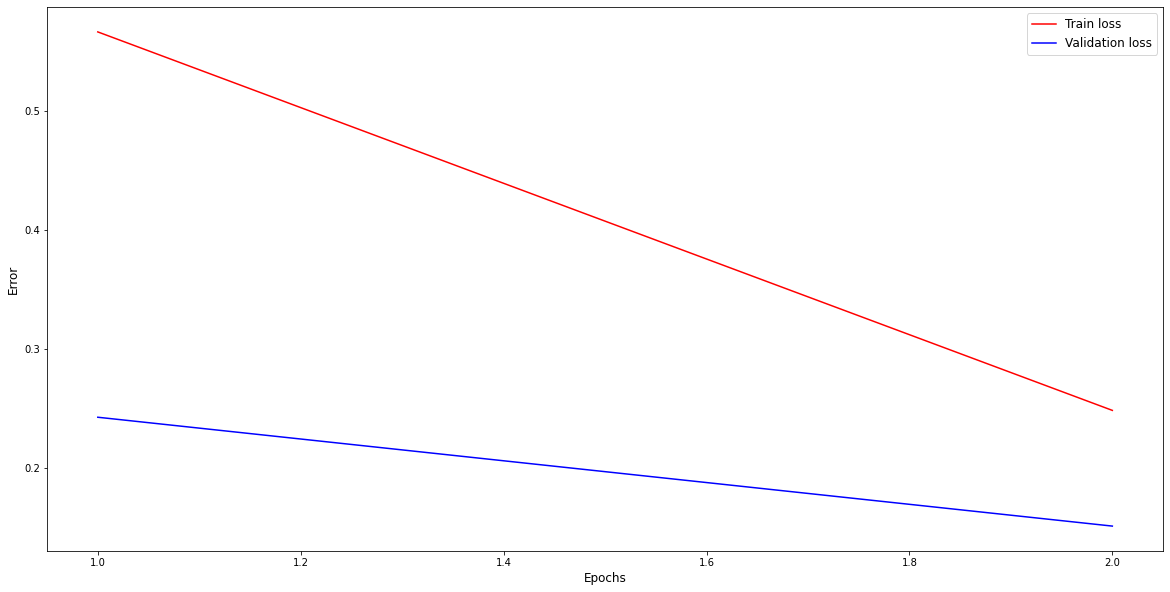

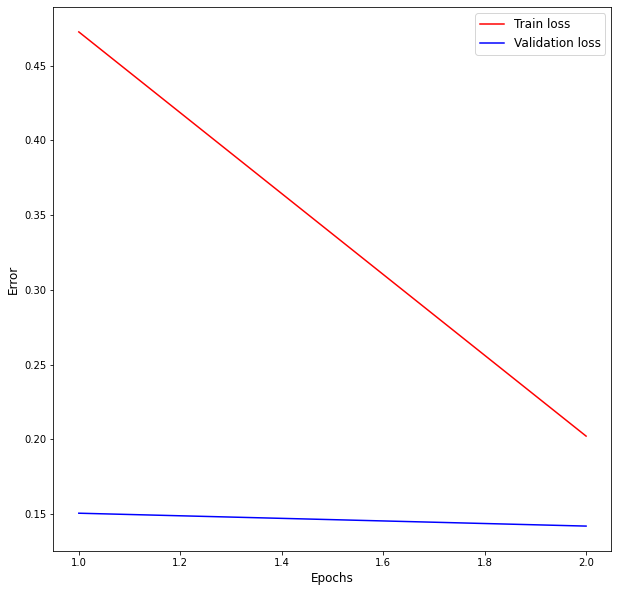

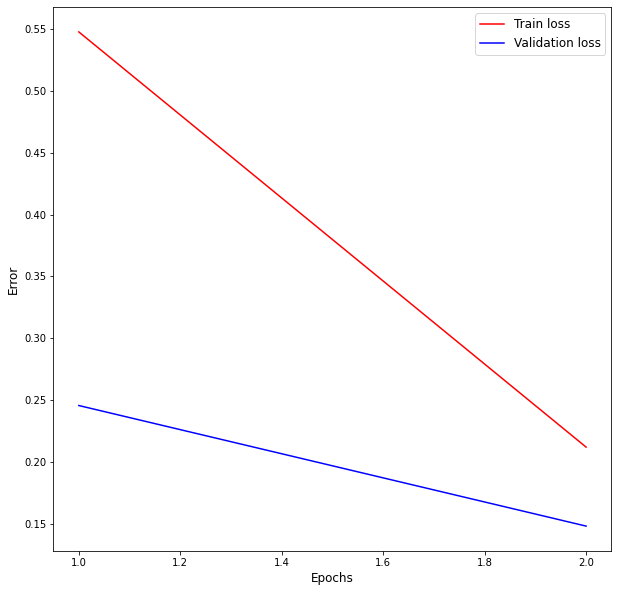

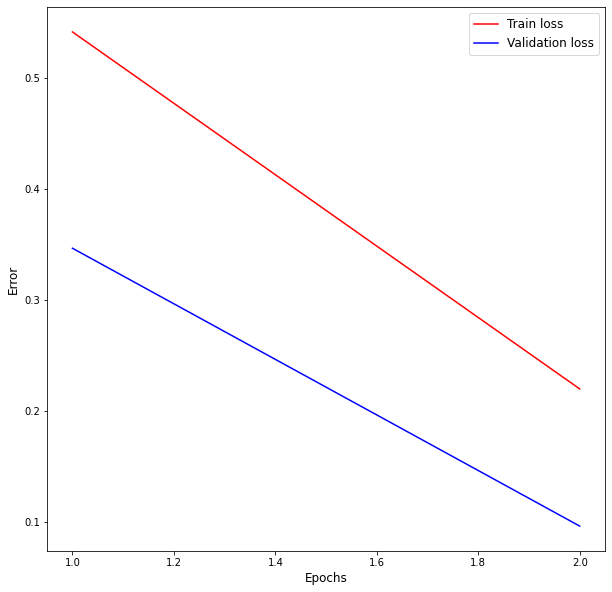

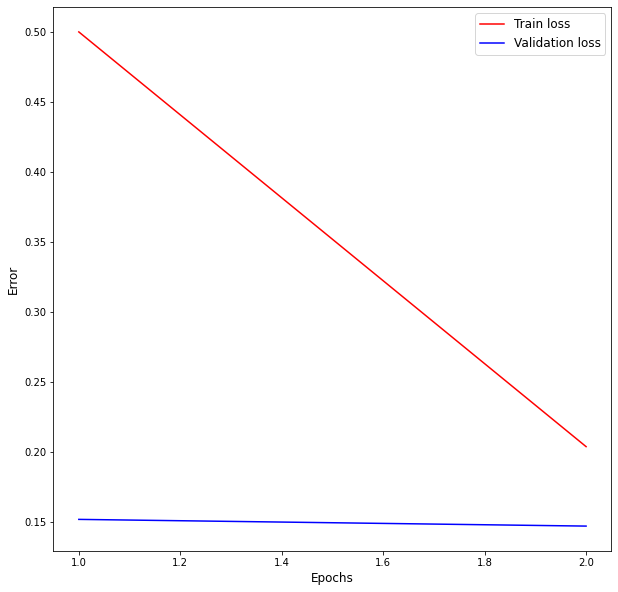

In [36]:
model_name = "squeezenet"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=500, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## AlexNet

In [ ]:
model_name = "alexnet"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=500, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## VGG-11

In [ ]:
model_name = "vgg11"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=2, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## ResNet34

In [ ]:
model_name = "resnet34"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=2, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## DenseNet-121

In [ ]:
model_name = "densenet121"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=2, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## SC-Net-50

In [ ]:
model_name = "scnet50"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=2, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

## SCNet-50-v1d

In [23]:
model_name = "scnet50_v1d"

date_time = strftime("%Y%m%d%H%M%S", gmtime())
dir_checkpoint= 'checkpoints/CV/'+model_name+"_"+date_time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4

for kfold in range(0,5):

    train_loader = get_dataset_dataloader(dataset_full_all[kfold][0], 
                                          input_channels=3, batch_size=batch_size)
    
    validation_loader = get_dataset_dataloader(dataset_full_all[kfold][1], 
                                               input_channels=3, batch_size=batch_size)

    model = get_dl_model(model_name, True)

    train_losses, val_losses = train_net(net=model, device=device, train_loader=train_loader, 
                                         validation_loader=validation_loader, 
                                         epochs=2, batch_size=batch_size, lr=0.0001, kfold=kfold)

    plot_losses(train_losses, val_losses)

    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_train.csv", np.array(train_losses))
    np.savetxt("losses/"+model_name+"_"+date_time+"_"+str(kfold)+"_validation.csv", np.array(train_losses))

TypeError: get_dataset_dataloader() got multiple values for argument 'input_channels'